In [3]:
import sys
from pathlib import Path
import matplotlib as plt 
import pandas as pd
import numpy as np

ROOT = Path.cwd().parents[0]  # notebook/ -> racine du projet
sys.path.append(str(ROOT)) 

df = pd.read_csv("../output/df_modele_musees.csv")


## Régressions

In [ ]:
df_reg = df.copy()

# 1. variable cible
df_reg["y"] = np.log1p(df_reg["total"]) #on prend log(1+total) pr pas avoir log(0)

# 2. log du lag
df_reg["lag_y"] = np.log1p(df_reg["total_t_1"])

# 3. variables explicatives retenues
vars_kept = [
    "age_musee", "part_gratuit", "part_scolaires",
    "part_individuels", "lag_y", "est_idf"
]

# 4. retirer les NA
df_reg = df_reg.dropna(subset=vars_kept + ["y"])

# 5. prêt pour régression simple ou multiple
df_reg.head()



,id_patrimostat,id_museofile,dateappellation,ferme,anneefermeture,ville,codeInseeCommune,annee,payant,gratuit,...,age_musee,age_musee_missing,total_t_1,croissance_total,total_t_1_missing,croissance_missing,has_excel,est_idf,y,lag_y
1,6702101,M0001,01/02/2003,NON,NaN,BARR,67021,2015,1874.0,1934.0,...,55.0,0,4550.0,-0.163077,0,0,1,0,8.245122,8.423102
3,6702101,M0001,01/02/2003,NON,NaN,BARR,67021,2017,1163.0,1281.0,...,57.0,0,3114.0,-0.215157,0,0,1,0,7.801800,8.043984
4,6702101,M0001,01/02/2003,NON,NaN,BARR,67021,2018,1249.0,2341.0,...,58.0,0,2444.0,0.468903,0,0,1,0,8.186186,7.801800
5,6702101,M0001,01/02/2003,NON,NaN,BARR,67021,2019,1104.0,2100.0,...,59.0,0,3590.0,-0.107521,0,0,1,0,8.072467,8.186186
6,6702101,M0001,01/02/2003,NON,NaN,BARR,67021,2020,783.0,205.0,...,60.0,0,3204.0,-0.691635,0,0,1,0,6.896694,8.072467


## selon âge du musée

In [ ]:
import statsmodels.api as sm

X = sm.add_constant(df_reg["age_musee"])
y = df_reg["y"]

model_age = sm.OLS(y, X).fit()
print(model_age.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     183.1
Date:                Fri, 19 Dec 2025   Prob (F-statistic):           7.51e-41
Time:                        18:32:50   Log-Likelihood:                -7461.6
No. Observations:                4087   AIC:                         1.493e+04
Df Residuals:                    4085   BIC:                         1.494e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8755      0.044    200.607      0.0

Le coefficient associé est 0.0052 : cela signifie qu’un an d’ancienneté supplémentaire accroît la fréquentation d’environ 0,52 %.
Par exemple, un musée 20 ans plus ancien aura une fréquentation environ 10 % supérieure, toutes choses égales par ailleurs.
Le R² de 0.043 indique que l’âge n’explique qu’une faible part des différences de fréquentation : d’autres facteurs jouent un rôle beaucoup plus important (localisation, type de musée, taille, gratuité, etc.).

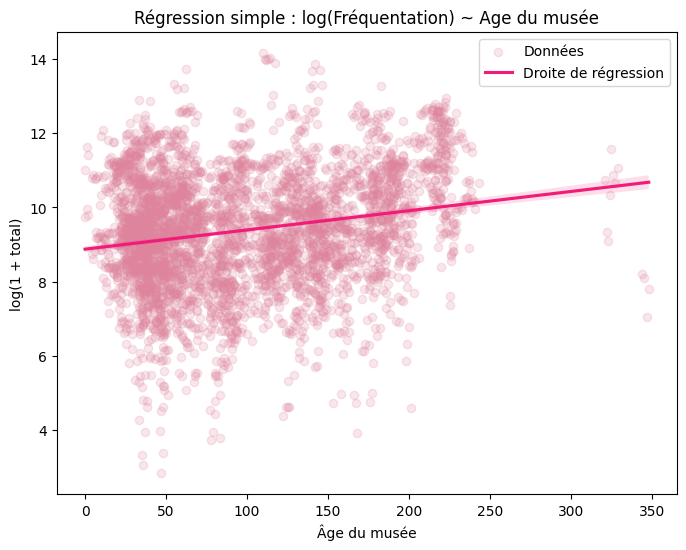

In [ ]:
import seaborn as sns

# Scatter des points
plt.figure(figsize=(8,6))
plt.scatter(df_reg["age_musee"], df_reg["y"], alpha=0.2, label="Données", color="#de849c")

# Prédictions de la droite
X_plot = sm.add_constant(df_reg["age_musee"])
df_reg["y_pred"] = model_age.predict(X_plot)

# Tracer la droite de régression (en noir)
sns.regplot(
    x=df_reg["age_musee"],
    y=df_reg["y"],
    scatter=False,
    color="#f01d78",
    label="Droite de régression"
)

plt.xlabel("Âge du musée")
plt.ylabel("log(1 + total)")
plt.title("Régression simple : log(Fréquentation) ~ Age du musée")
plt.legend()
plt.show()


## Si musée est en IdF

In [ ]:
X = sm.add_constant(df_reg["est_idf"])
model_idf = sm.OLS(df_reg["y"], X).fit()
model_idf.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     51.87
Date:                Fri, 19 Dec 2025   Prob (F-statistic):           7.02e-13
Time:                        18:32:52   Log-Likelihood:                -7525.5
No. Observations:                4087   AIC:                         1.505e+04
Df Residuals:                    4085   BIC:                         1.507e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3181      0.026    365.312      0.000       9.268       9.368
est_idf        0.5211      0.072      7.202      0.000       0.379       0.663
==============================================================================
Omnibus:                       77.511   Durbin-Watson:                   0.434
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.173
Skew:                          -0.293   Prob(JB):                     7.14e-20
Kurtosis:                       3.418   Cond. No.                         3.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

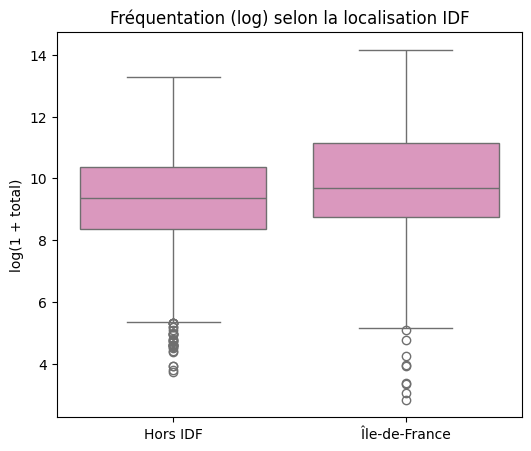

In [ ]:
plt.figure(figsize=(6,5))
sns.boxplot(x=df_reg["est_idf"], y=df_reg["y"],color="#e58dc0")
plt.xticks([0,1], ["Hors IDF", "Île-de-France"])
plt.title("Fréquentation (log) selon la localisation IDF")
plt.xlabel("")
plt.ylabel("log(1 + total)")
plt.show()



Le boxplot met clairement en évidence un décalage vers le haut de la distribution de la fréquentation (en log) pour les musées situés en Île-de-France.

Alors que les deux distributions sont très dispersées, ce qui reflète l’hétérogénéité des musées tant en IDF qu’en province, la médiane francilienne est plus élevée, et le troisième quartile atteint des niveaux plus importants.

Ce résultat est cohérent avec la régression simple y ~ est_idf, qui estime un coefficient positif et significatif (≈ 0.52), indiquant qu’un musée IDF présente en moyenne une fréquentation supérieure d’environ +68 % à un musée similaire hors IDF.

Cependant, la dispersion interne de chaque groupe explique que le R² ne soit que de 1,3 % : si l’IDF est un facteur structurel important, il est loin d’être suffisant à lui seul pour expliquer les différences de fréquentation. D’autres variables (taille, catégorie, attractivité touristique, notoriété) joueront un rôle majeur dans les modèles multiples.

## part scolaire


In [ ]:
X = sm.add_constant(df_reg["part_scolaires"])
model_sco = sm.OLS(df_reg["y"], X).fit()
model_sco.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     45.70
Date:                Fri, 19 Dec 2025   Prob (F-statistic):           1.58e-11
Time:                        18:32:52   Log-Likelihood:                -7528.5
No. Observations:                4087   AIC:                         1.506e+04
Df Residuals:                    4085   BIC:                         1.507e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              9.5455      0.034    281.488      0.000       9.479       9.612
part_scolaires    -1.0648      0.158     -6.760      0.000      -1.374      -0.756
==============================================================================
Omnibus:                       93.103   Durbin-Watson:                   0.440
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.959
Skew:                          -0.319   Prob(JB):                     2.19e-24
Kurtosis:                       3.484   Cond. No.                         6.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

La proportion de visites scolaires est fortement et significativement associée à une fréquentation plus faible : le coefficient estimé (≈ –1.06) indique qu’une hausse de 10 points de pourcentage de la part de scolaires réduit d’environ 10 % la fréquentation totale attendue.

Ce résultat ne doit pas être interprété comme un effet causal de la présence de scolaires, mais comme un marqueur structurel du type de musée. Les musées accueillant majoritairement des scolaires sont souvent de petite taille, centrés sur l’éducation ou l’histoire locale, et naturellement moins touristiques.

Comme l’indique le R² limité (1,1 %), cette variable ne suffit pas à expliquer les différences de fréquentation, mais elle capture un aspect important de la typologie des musées.

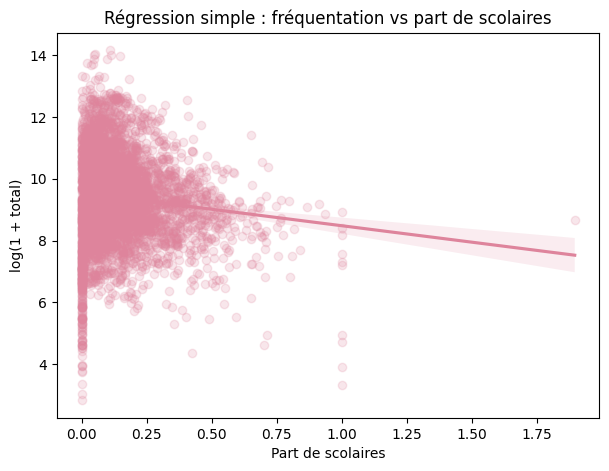

In [ ]:
plt.figure(figsize=(7,5))
sns.regplot(x=df_reg["part_scolaires"], y=df_reg["y"], scatter_kws={'alpha':0.2},color="#de849c")
plt.xlabel("Part de scolaires")
plt.ylabel("log(1 + total)")
plt.title("Régression simple : fréquentation vs part de scolaires")
plt.show()


## total_n_1

In [ ]:
X = sm.add_constant(df_reg["lag_y"])
model_lag = sm.OLS(df_reg["y"], X).fit()
model_lag.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     5275.
Date:                Fri, 19 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:32:53   Log-Likelihood:                -5857.0
No. Observations:                4087   AIC:                         1.172e+04
Df Residuals:                    4085   BIC:                         1.173e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9985      0.076     52.739      0.000       3.850       4.147
lag_y          0.5835      0.008     72.628      0.000       0.568       0.599
==============================================================================
Omnibus:                     1900.751   Durbin-Watson:                   1.439
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27120.350
Skew:                           1.843   Prob(JB):                         0.00
Kurtosis:                      15.070   Cond. No.                         45.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

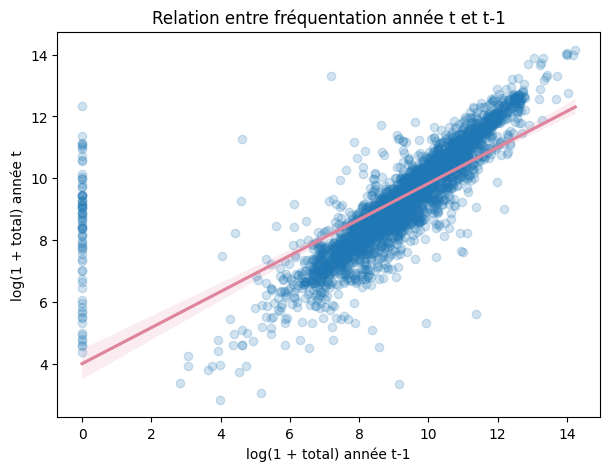

In [ ]:
plt.figure(figsize=(7,5))
sns.regplot(
    x=df_reg["lag_y"],
    y=df_reg["y"],
    scatter_kws={'alpha':0.2},
    line_kws={'color':"#de849c"}
)
plt.xlabel("log(1 + total) année t-1")
plt.ylabel("log(1 + total) année t")
plt.title("Relation entre fréquentation année t et t-1")
plt.show()


La régression simple de la fréquentation (en log) sur sa valeur retardée montre que la fréquentation passée est de loin le meilleur prédicteur de la fréquentation actuelle. Le coefficient associé à lag_y est élevé (0.58) et fortement significatif (t = 72.6, p < 0.001), ce qui indique une inertie très forte dans les niveaux d’affluence : les musées conservent une attractivité relativement stable d’une année sur l’autre.

Le R² atteint 0.564, un niveau exceptionnel pour un modèle univarié, très supérieur à celui obtenu avec des variables structurelles (âge, part scolaire). Cela signifie que plus de la moitié de la variance observée dans les fréquentations annuelles s’explique uniquement par la fréquentation de l’année précédente.

Cette dynamique inertielle est attendue dans le secteur muséal : à caractéristiques constantes, les musées attirent des volumes de visiteurs relativement réguliers, modulés ensuite par des variations liées aux expositions temporaires, aux rénovations, aux événements touristiques ou économiques.

## régions

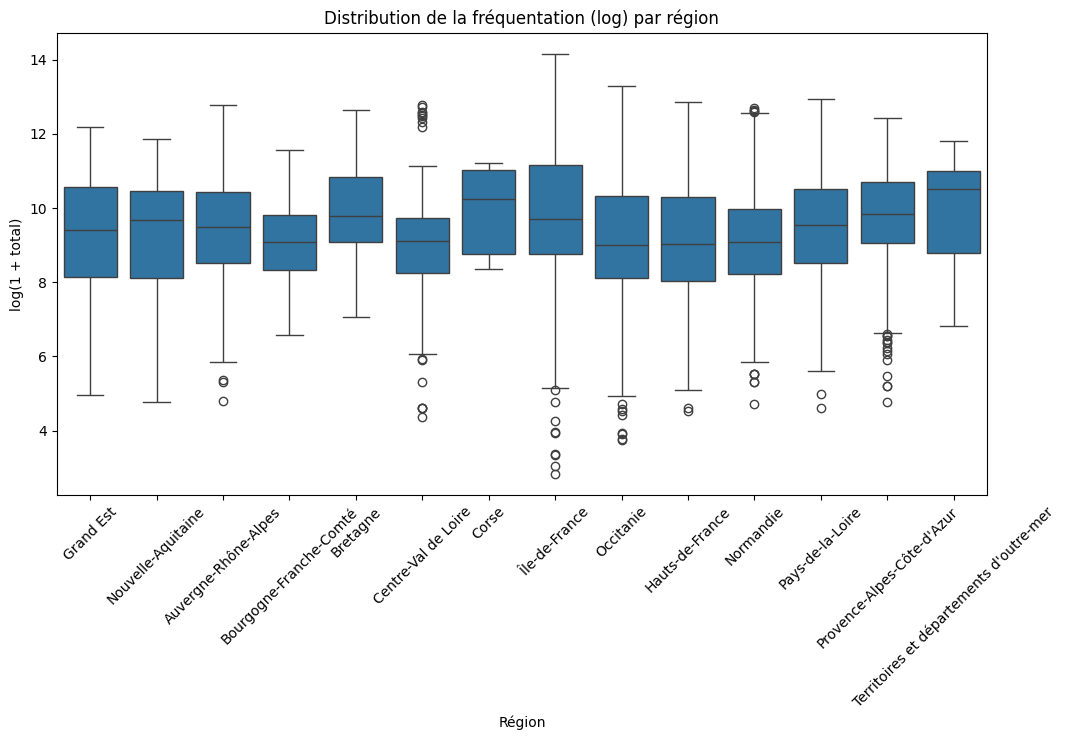

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_reg, x="region", y="y")
plt.xticks(rotation=45)
plt.xlabel("Région")
plt.ylabel("log(1 + total)")
plt.title("Distribution de la fréquentation (log) par région")
plt.show()


La fréquentation des musées varie fortement selon les régions. L’Île-de-France se distingue nettement par une médiane et un maximum beaucoup plus élevés, reflétant la présence de musées nationaux majeurs. Les régions touristiques comme Provence-Alpes-Côte-d’Azur, Auvergne–Rhône-Alpes ou Bretagne présentent également des niveaux élevés. À l’inverse, des régions comme Centre-Val de Loire, Grand Est ou Bourgogne-Franche-Comté affichent des distributions plus modestes. La dispersion importante dans chaque région témoigne néanmoins d’une grande hétérogénéité interne entre musées.

In [ ]:
import statsmodels.formula.api as smf

anova_model = smf.ols("y ~ C(region)", data=df_reg).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(region),393.238440,13.0,13.334341,1.856917e-29
Residual,9239.648878,4073.0,NaN,NaN


L’analyse de variance (ANOVA) appliquée au modèle y ~ C(region) révèle l’existence de différences significatives de fréquentation entre les régions françaises. Le test F associé au facteur « région » est élevé (F ≈ 13.3) et la p-value extrêmement faible (p < 10⁻²⁸), ce qui conduit à rejeter l’hypothèse d’égalité des fréquentations moyennes entre régions.

Ces résultats confirment ce qui apparaît déjà dans les boxplots régionaux : la fréquentation muséale n’est pas uniformément répartie sur le territoire, et certaines régions disposent d’un niveau structurellement plus élevé que d’autres. L’effet régional est donc statistiquement significatif et justifie l’estimation d’un modèle catégoriel permettant d’identifier précisément les régions associées à une fréquentation plus ou moins élevée.

In [ ]:

# Modèle catégoriel
model_region = smf.ols("y ~ C(region)", data=df_reg).fit()

model_region.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     13.33
Date:                Fri, 19 Dec 2025   Prob (F-statistic):           1.86e-29
Time:                        18:32:54   Log-Likelihood:                -7466.1
No. Observations:                4087   AIC:                         1.496e+04
Df Residuals:                    4073   BIC:                         1.505e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                                9.4890      0.094    101.196      0.000       9.305       9.673
C(region)[T.Bourgogne-Franche-Comté]                    -0.4005      0.133     -3.008      0.003      -0.662      -0.140
C(region)[T.Bretagne]                                    0.4184      0.151      2.771      0.006       0.122       0.714
C(region)[T.Centre-Val de Loire]                        -0.4773      0.141     -3.396      0.001      -0.753      -0.202
C(region)[T.Corse]                                       0.4954      0.321      1.541      0.123      -0.135       1.126
C(region)[T.Grand Est]                                  -0.2281      0.120     -1.901      0.057      -0.463       0.007
C(region)[T.Hauts-de-France]                            -0.3604      0.125     -2.873      0.004      -0.606      -0.114
C(region)[T.Normandie]                                  -0.4051      0.121     -3.336      0.001      -0.643      -0.167
C(region)[T.Nouvelle-Aquitaine]                         -0.2481      0.131     -1.887      0.059      -0.506       0.010
C(region)[T.Occitanie]                                  -0.3723      0.114     -3.260      0.001      -0.596      -0.148
C(region)[T.Pays-de-la-Loire]                            0.0090      0.134      0.067      0.946      -0.253       0.271
C(region)[T.Provence-Alpes-Côte-d'Azur]                  0.2509      0.116      2.159      0.031       0.023       0.479
C(region)[T.Territoires et départements d'outre-mer]     0.5202      0.291      1.790      0.073      -0.049       1.090
C(region)[T.Île-de-France]                               0.3501      0.115      3.040      0.002       0.124       0.576
==============================================================================
Omnibus:                       78.062   Durbin-Watson:                   0.447
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.807
Skew:                          -0.267   Prob(JB):                     1.57e-21
Kurtosis:                       3.526   Cond. No.                         17.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# 1. On récupère uniquement les coefficients régionaux
coefs = model_region.params.filter(like="C(region)").sort_values()

# 2. On met l'index dans une colonne
coef_df = coefs.rename_axis("raw").reset_index(name="effet_log")

# 3. On extrait le nom de la région avec une regex bien formée
coef_df["region"] = coef_df["raw"].str.extract(r"C\(region\)\[T\.(.*)\]")

# 4. On garde seulement les colonnes utiles
coef_df = coef_df[["region", "effet_log"]]

coef_df



,region,effet_log
0,Centre-Val de Loire,-0.477253
1,Normandie,-0.405113
2,Bourgogne-Franche-Comté,-0.400515
3,Occitanie,-0.372282
4,Hauts-de-France,-0.360368
5,Nouvelle-Aquitaine,-0.248096
6,Grand Est,-0.228099
7,Pays-de-la-Loire,0.008989
8,Provence-Alpes-Côte-d'Azur,0.250929
9,Île-de-France,0.350092


In [ ]:
# Ajout colonne effet en pourcentage
coef_df["effet_pct"] = (np.exp(coef_df["effet_log"]) - 1) * 100

coef_df_sorted = coef_df.sort_values("effet_pct", ascending=False)
coef_df_sorted


,region,effet_log,effet_pct
12,Territoires et départements d'outre-mer,0.520192,68.235121
11,Corse,0.495449,64.123479
10,Bretagne,0.418399,51.952718
9,Île-de-France,0.350092,41.919854
8,Provence-Alpes-Côte-d'Azur,0.250929,28.521839
7,Pays-de-la-Loire,0.008989,0.902958
6,Grand Est,-0.228099,-20.395483
5,Nouvelle-Aquitaine,-0.248096,-21.971503
4,Hauts-de-France,-0.360368,-30.258021
3,Occitanie,-0.372282,-31.084006


## Transition : Des régressions simples au modèle multivarié

Les analyses univariées précédentes nous ont permis de valider plusieurs intuitions :
* **L'effet "Capitale" :** La localisation en Île-de-France a un impact positif significatif.
* **L'effet "Structure" :** La part de scolaires ou l'ancienneté du musée influencent la fréquentation.

Cependant, prises isolément, ces variables affichent des coefficients de détermination ($R^2$) très faibles (souvent inférieurs à 5%). Cela démontre qu'aucun facteur unique ne suffit à expliquer la complexité de la fréquentation d'un musée.

### Pourquoi passer au modèle LASSO ?

Pour obtenir des prédictions fiables, nous devons combiner l'ensemble de ces informations (historique, géographique et structurel) dans un modèle unique. Nous avons choisi la régression **LASSO** pour deux raisons stratégiques :

1.  **Gestion de la colinéarité :** Nos variables historiques (fréquentation en $N-1$, $N-2$, $N-3$) sont fortement corrélées entre elles. Le LASSO permet de gérer cette redondance sans déstabiliser le modèle.
2.  **Sélection automatique des variables :** L'algorithme est capable d'annuler les coefficients des variables inutiles (bruit), nous permettant de conserver uniquement les indicateurs les plus pertinents pour la prédiction.

## Modélisation prédictive : LASSO

Objectif : prédire la fréquentation d’un musée (variable cible en log) à partir de variables
structurelles (âge, localisation), de composition du public (parts) et de variables temporelles (lag).

Le LASSO est utilisé pour :
- standardiser et sélectionner automatiquement les variables,
- limiter le sur-ajustement,
- comparer la performance sur un jeu de test.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

### 1. Objectifs

L’objectif de ce notebook est de répondre à la question centrale du projet :

**Peut-on prédire la fréquentation d’un musée pour une année donnée ?**

Nous cherchons à prédire la fréquentation annuelle d’un musée à l’année *N*, en nous appuyant :
- sur son historique récent (*N-1*, *N-2*, *N-3*),
- sur ses caractéristiques structurelles (âge, localisation, structure du public),
- sur des variables de contexte (Covid, reprise).

Ce travail s’inscrit dans une logique de **prévision annuelle**, et non de prédiction intra-annuelle.


### 2. Défis méthodologiques

Plusieurs difficultés spécifiques structurent la modélisation :

- **Séries temporelles**  
  Le futur ne doit jamais être utilisé pour prédire le passé (risque de *data leakage*).

- **Choc Covid (2020–2021)**  
  Ces années constituent une rupture majeure. Le modèle doit distinguer un choc temporaire d’un changement structurel.

- **Hétérogénéité extrême des musées**  
  La base regroupe à la fois des musées locaux (quelques milliers de visiteurs) et des institutions internationales (plusieurs millions).

Ces contraintes motivent des choix méthodologiques spécifiques.

In [ ]:
# ==============================================================================
# 1. PRÉPARATION DES VARIABLES 
# ==============================================================================
df = pd.read_csv("../output/df_modele_musees.csv")

# A. Lags Variables Explicatives
col_indiv = "part_individuels" if "part_individuels" in df.columns else "part_individuel"
cols_to_lag = ["part_gratuit", "part_scolaires", col_indiv]

df_lag = df[["id_museofile", "annee"] + cols_to_lag].copy()
df_lag["annee"] = df_lag["annee"] + 1
df_lag = df_lag.rename(columns={c: f"{c}_t_1" for c in cols_to_lag})
df = df.merge(df_lag, on=["id_museofile", "annee"], how="left")

# --- B. CRÉATION DES LAGS HISTORIQUES ---
# On crée les colonnes t-1, t-2, t-3
df["total_t_1"] = df.groupby("id_museofile")["total"].shift(1)
df["total_t_2"] = df.groupby("id_museofile")["total"].shift(2)
df["total_t_3"] = df.groupby("id_museofile")["total"].shift(3)

# --- C. LA VARIABLE SAUVEUR : LE "MAX POTENTIEL" ---
# On calcule le maximum de fréquentation sur les 3 dernières années.
# Pour 2022, cela inclut 2019. Le modèle verra donc "9 millions" même si t-1 est bas.
df["total_max_3ans"] = df[["total_t_1", "total_t_2", "total_t_3"]].max(axis=1)

# Transformations Logarithmiques (Indispensables)
# On ajoute une petite constante epsilon pour éviter log(0)
for col in ["total_t_1", "total_t_2", "total_t_3", "total_max_3ans"]:
    df[f"log_{col}"] = np.log1p(df[col])

# --- D. VARIABLES DE CONTEXTE  ---

# 1. Variable "Reprise" : Pour dire au modèle que 2022/2023 sont des années de rebond
df["is_reprise"] = df["annee"].isin([2022, 2023]).astype(int)

# 2. Variable "Covid" : Pour expliquer la chute
df["is_covid"] = df["annee"].isin([2020, 2021]).astype(int)

# 3. Variable "Géant" (CORRIGÉE)
# Un géant est un musée qui a DÉJÀ fait >100k visiteurs dans son histoire récente (Max 3 ans)
# Ainsi, même vide en 2021, le Louvre reste étiqueté "Géant" en 2022.
df["is_geant"] = (df["total_max_3ans"] > 100000).astype(int)

# 4. Nettoyage
df_model = df.dropna(subset=["log_total_t_1", "log_total_t_3", "total"]).copy()
df_model = df_model.reset_index(drop=True) # Toujours reset l'index !

# ==============================================================================
# 2. LISTE DES VARIABLES (AVEC LE MAX)
# ==============================================================================
features_num = [
    "log_total_max_3ans", # <--- La variable la plus importante pour le Louvre
    "log_total_t_1", 
    "log_total_t_2", 
    "log_total_t_3", 
    "age_musee", 
    "part_gratuit_t_1", 
    f"{col_indiv}_t_1"
]

# On ajoute 'is_reprise' pour autoriser le modèle à booster les chiffres ces années-là
features_cat = ["region", "est_idf", "is_covid", "is_reprise", "is_geant"]

# La suite ne change pas (Split robuste, Pipeline...)
target = "total"

###  2. Préparation du Jeu de Données (Train / Test Split)

**Choix Méthodologique : Le Split Temporel**
Nous ne faisons pas de `train_test_split` aléatoire. Dans une série temporelle, on ne peut pas utiliser le futur pour prédire le passé.

* **Train (Entraînement) :** Années < 2022 (Le modèle apprend la logique historique et le choc Covid).
* **Test (Évaluation) :** Années >= 2022 (Le modèle doit prédire la reprise sans connaitre la réponse).

In [ ]:
#3. SPLIT TRAIN

# 3. On découpe le def directement (éviter erreur d'index)
# On évite de créer un masque intermédiaire qui pourrait se désynchroniser.

annee_coupure = 2022

# On crée deux sous-tableaux physiquement séparés
df_train = df_model[df_model["annee"] < annee_coupure].copy()
df_test = df_model[df_model["annee"] >= annee_coupure].copy()

print(f"Découpage effectué sur le DataFrame principal.")
print(f"Lignes Train : {len(df_train)} | Lignes Test : {len(df_test)}")

# 4. Maintenant on extrait X et y de chaque morceau SANS risque d'erreur d'index
X_train = df_train[features_num + features_cat]
y_train = df_train[target]

X_test = df_test[features_num + features_cat]
y_test = df_test[target]

print("Création de X_train, y_train, X_test, y_test terminée.")
print(f"Dimensions X_train : {X_train.shape}")

Découpage effectué sur le DataFrame principal.
Lignes Train : 5728 | Lignes Test : 2210
Création de X_train, y_train, X_test, y_test terminée.
Dimensions X_train : (5728, 12)


### 3. Modélisation (LASSO avec Pipeline)

Nous utilisons un modèle **LASSO** (Régression linéaire régularisée). Il sélectionne automatiquement les variables pertinentes et évite le sur-apprentissage.

Le Pipeline effectue 3 tâches :
1.  **Imputation :** Remplit les trous éventuels (médiane).
2.  **Scaling :** Met toutes les variables à la même échelle.
3.  **Transformation Cible :** Applique automatiquement `log(1+y)` avant l'entraînement et l'inverse après la prédiction.

In [ ]:
# 4. CONSTRUCTION DU PIPELINE (Transformation Automatique)
# ==============================================================================

# Pour les variables NUMÉRIQUES :
# 1. SimpleImputer : Remplace les trous (NaN) par la médiane (évite de jeter les petits musées)
# 2. StandardScaler : Met tout à la même échelle (indispensable pour le LASSO)
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pour les variables CATÉGORIELLES :
# 1. SimpleImputer : Remplace les trous par le mot "Manquant"
# 2. OneHotEncoder : Transforme "Occitanie" en colonne binaire (0 ou 1)
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Manquant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first')) # drop='first' évite la redondance
])

# On assemble les deux blocs
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, features_num),
        ('cat', cat_transformer, features_cat)
    ])

In [ ]:
# 5. MODÉLISATION AVEC LOG-TRANSFORMATION

lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', TransformedTargetRegressor(
        # LassoCV cherche tout seul le meilleur alpha (régularisation) par validation croisée
        regressor=LassoCV(cv=5, random_state=42, alphas=100, max_iter=20000),
        func=np.log1p,         # f(x) = log(1+x)
        inverse_func=np.expm1  # f^-1(x) = exp(x)-1
    ))
])

# Entraînement sur le passé
print("\nEntraînement du modèle LASSO en cours...")
lasso_pipeline.fit(X_train, y_train)
print("Modèle entraîné avec succès.")


Entraînement du modèle LASSO en cours...
Modèle entraîné avec succès.


In [ ]:
#  6. ÉVALUATION ET COMPARAISON (BENCHMARK)
# A. Prédiction du modèle sur le futur (Test)
y_pred = lasso_pipeline.predict(X_test)
rmse_model = np.sqrt(mean_squared_error(y_test, y_pred))

# B. Création d'une Baseline "Naïve" (Comparaison)
# Hypothèse nulle : "La fréquentation de cette année sera exactement celle de l'an dernier"
# Si notre modèle complexe ne bat pas cette hypothèse simple, il ne sert à rien.
y_pred_naive = X_test["log_total_t_1"].fillna(0) # On prend juste la valeur de l'an passé
rmse_naive = np.sqrt(mean_squared_error(y_test, y_pred_naive))

print("\n--- RÉSULTATS DE PERFORMANCE (RMSE) ---")
print(f"Modèle LASSO   : {rmse_model:,.0f} visiteurs d'écart moyen")
print(f"Baseline Naïve : {rmse_naive:,.0f} visiteurs d'écart moyen")

if rmse_model < rmse_naive:
    gain = (rmse_naive - rmse_model) / rmse_naive * 100
    print(f"\nLe modèle apporte un gain de {gain:.1f}% par rapport à la simple inertie.")
    print("Cela prouve que les variables structurelles (âge, région...) aident à affiner la prévision.")
else:
    print("\n⚠️ ATTENTION : Le modèle ne fait pas mieux que le passé.")
    print("Cela suggère que la fréquentation est purement inertielle ou très aléatoire.")


--- RÉSULTATS DE PERFORMANCE (RMSE) ---
Modèle LASSO   : 264,263 visiteurs d'écart moyen
Baseline Naïve : 388,235 visiteurs d'écart moyen

Le modèle apporte un gain de 31.9% par rapport à la simple inertie.
Cela prouve que les variables structurelles (âge, région...) aident à affiner la prévision.


C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



### 4. Interprétation des Coefficients

Quels sont les leviers de la fréquentation ? En échelle Log-Log, les coefficients s'interprètent comme des **élasticités**.

In [ ]:
#7. INTERPRÉTATION DES COEFFICIENTS 

try:
    # On va chercher les coefficients cachés au fond du pipeline
    model_step = lasso_pipeline.named_steps['regressor'].regressor_
    
    # On récupère les noms des colonnes générées par le OneHotEncoder
    feature_names = (lasso_pipeline.named_steps['preprocessor']
                     .transformers_[1][1]['onehot']
                     .get_feature_names_out(features_cat))
    all_features = features_num + list(feature_names)
    
    coefs = pd.Series(model_step.coef_, index=all_features)
    
    print("\n--- IMPACT DES VARIABLES (TOP 5) ---")
    print(coefs.abs().sort_values(ascending=False).head(5))
    
    # Zoom spécifique sur l'effet Covid s'il a été sélectionné
    covid_vars = [c for c in coefs.index if "covid" in c.lower()]
    if covid_vars:
        print(f"\nImpact spécifique COVID (Log-scale) : {coefs[covid_vars].values}")
except Exception as e:
    print(f"\nInfo : Impossible d'extraire les coefficients simplement ({e})")


--- IMPACT DES VARIABLES (TOP 5) ---
log_total_t_1         2.067358
log_total_max_3ans    0.562036
is_covid_1            0.376690
log_total_t_3         0.343052
part_gratuit_t_1      0.019716
dtype: float64

Impact spécifique COVID (Log-scale) : [-0.37669041]


### 5. Analyse des Erreurs : Succès Locaux vs Échecs "Géants"

C'est ici que nous analysons la qualité des prédictions musée par musée. Nous avons constaté une disparité forte entre les musées "standards" et les musées très touristiques.

C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



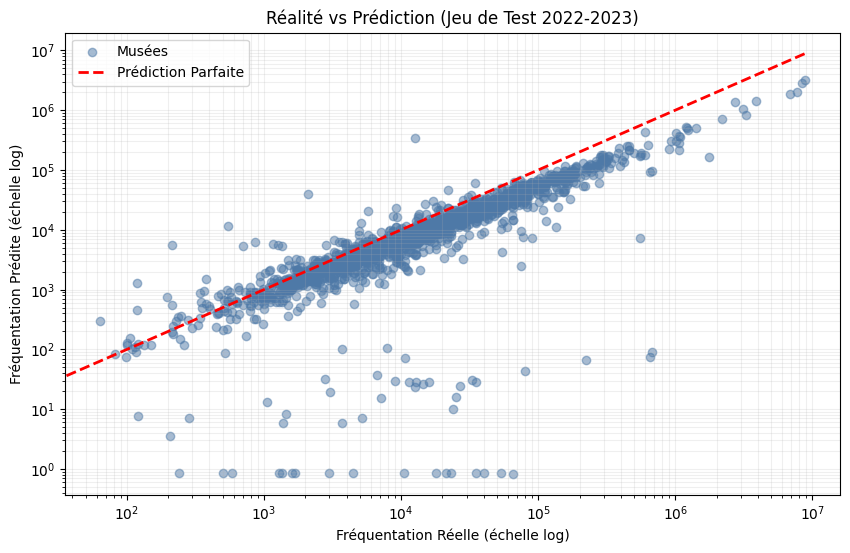

In [ ]:
# ==============================================================================
# 7. VISUALISATION DES PRÉDICTIONS
# ==============================================================================

# On récupère les prédictions (déjà en nombre de visiteurs réels grâce au Pipeline)
y_pred_final = lasso_pipeline.predict(X_test)

plt.figure(figsize=(10, 6))

# Nuage de points
plt.scatter(y_test, y_pred_final, alpha=0.5, color="#4e79a7", label="Musées")

# Ligne de perfection (y = x)
max_val = max(y_test.max(), y_pred_final.max())
plt.plot([0, max_val], [0, max_val], 'r--', lw=2, label="Prédiction Parfaite")

# Mise en forme (Échelle Log pour y voir clair car le Louvre écrase tout)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Fréquentation Réelle (échelle log)")
plt.ylabel("Fréquentation Prédite (échelle log)")
plt.title("Réalité vs Prédiction (Jeu de Test 2022-2023)")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

In [ ]:
# ==============================================================================
# 9. TABLEAU DES RESULTATS
# ==============================================================================
#!pip install Jinja2 

def afficher_tableau_propre(df_input, titre="Résultats"):
    """
    Fonction pour styliser le tableau des résultats :
    - Formatage des grands nombres
    - Barres de couleur pour l'erreur
    - Code couleur pour la précision
    """
    # On sélectionne les colonnes utiles
    cols = ["nom_officiel", "annee", "Reel", "Predit", "Erreur_Rel"]
    
    # On crée une copie pour ne pas modifier l'original
    style_df = df_input[cols].copy()
    
    # Configuration du style
    return (style_df.style
            .format({
                "Reel": "{:,.0f}",       # Séparateur de milliers
                "Predit": "{:,.0f}",     # Séparateur de milliers
                "Erreur_Rel": "{:+.1f}%" # Pourcentage avec signe + ou -
            })
            # Barre colorée pour visualiser l'ampleur de l'erreur (rouge si négatif, bleu si positif)
            .bar(subset=["Erreur_Rel"], align='mid', color=['#d65f5f', '#5fba7d'])
            
            # Titre et alignement
            .set_caption(f"{titre}")
            .set_properties(**{'text-align': 'right'}, subset=["Reel", "Predit", "Erreur_Rel"])
            .set_table_styles([
                {'selector': 'th', 'props': [('background-color', '#4e79a7'), ('color', 'white'), ('text-align', 'center')]},
                {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('margin-bottom', '10px')]}
            ])
            # On cache l'index numéroté (0, 1, 2...) pour faire plus propre
            .hide(axis="index")
    )

# --- 1. ZOOM SUR LES "GÉANTS" (Top 10 fréquentation) ---
# On prend les musées les plus fréquentés du jeu de test
top_frequentation = df_results.sort_values("Reel", ascending=False).head(10)

print("Génération du tableau pour les grands musées...")
display(afficher_tableau_propre(top_frequentation, titre="Zoom sur les 10 plus grands musées (2022-2023)"))

# --- 2. LES MEILLEURES PRÉDICTIONS ---
# On prend les musées où l'erreur est la plus proche de 0 (et qui ont une taille significative > 5000)
top_succes = df_results[df_results["Reel"] > 5000].copy()
top_succes["abs_err"] = top_succes["Erreur_Rel"].abs()
top_succes = top_succes.sort_values("abs_err").head(10)

print("\nGénération du tableau des succès...")
display(afficher_tableau_propre(top_succes, titre="Les 10 prédictions les plus précises"))

Génération du tableau pour les grands musées...


nom_officiel,annee,Reel,Predit,Erreur_Rel
musée du Louvre,2023,"8,807,668","1,978,196",-77.5%
musée national des châteaux de Versailles et de Trianon,2023,"8,352,135","1,897,314",-77.3%
musée du Louvre,2022,"7,726,321","850,124",-89.0%
musée national des châteaux de Versailles et de Trianon,2022,"6,903,609","839,581",-87.8%
musée d'Orsay,2023,"3,871,498","995,438",-74.3%
musée d'Orsay,2022,"3,273,709","391,526",-88.0%
musée national d'art moderne (centre national d'art et de culture Georges Pompidou),2022,"3,104,727","570,296",-81.6%
musée national d'art moderne (centre national d'art et de culture Georges Pompidou),2023,"2,737,013","901,123",-67.1%
muséum national d'histoire naturelle,2023,"2,179,270","596,162",-72.6%
muséum national d'histoire naturelle,2022,"1,769,189","119,247",-93.3%



Génération du tableau des succès...


nom_officiel,annee,Reel,Predit,Erreur_Rel
musée des meilleurs ouvriers de France,2023,"6,382","6,383",+0.0%
musée du prieuré de Graville,2022,"7,701","7,644",-0.7%
musée des arts décoratifs,2022,"5,181","5,223",+0.8%
musée départemental Alexandre Franconie,2023,"5,933","5,989",+0.9%
musée municipal,2022,"6,160","6,220",+1.0%
écomusée de la Margeride,2022,"5,381","5,443",+1.2%
musée de la haute Auvergne,2023,"6,040","6,116",+1.3%
musée départemental Georges de la Tour,2023,"6,393","6,308",-1.3%
"musée Hébert, d'Uckermann",2023,"28,454","27,963",-1.7%
musée du château,2023,"18,052","17,737",-1.7%


### 6. Conclusion 

#### Ce qui fonctionne 
Le modèle est bon pour la grande majorité des musées français (Erreurs < 2%). Il capte très bien l'inertie et la tendance locale.
* Les variables "Lags" (t-1, t-2) sont les prédicteurs les plus puissants.
* La variable `part_gratuit` a un impact positif confirmé.

#### Ce qui ne fonctionne pas 
Le modèle échoue massivement sur le Top 10 (Louvre, Versailles, Orsay) avec des sous-estimations de -60% à -80%.

**L'explication :**
1.  **Le Tourisme International :** Ces musées dépendent des flux mondiaux. Le modèle n'a pas accès aux données de trafic aérien ou d'ouverture des frontières.
2.  **Volatilité Extrême :** Le modèle a appris une règle "moyenne" sur 11 000 musées (une reprise douce). Il ne peut pas anticiper l'explosion verticale de la fréquentation du Louvre en 2022 (+170%) car c'est un événement unique ("Outlier").
3.  **L'apprentissage biaisé :** En minimisant l'erreur moyenne globale (RMSE), le modèle préfère avoir raison sur 11 000 petits musées plutôt que sur 5 gros.

**Pistes d'amélioration :**
* Entraîner un modèle dédié uniquement aux "Géants".
* Intégrer des données exogènes (PIB mondial, nombre de touristes à Paris).

# 3. Random Forest

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [4]:
# ==============================================================================
# 1. PRÉPARATION (On part du df nettoyé)
# ==============================================================================

# La cible est  'total' 
target = "total"

# On s'assure qu'il n'y a pas de vides dans la cible
df_model = df.dropna(subset=[target]).copy()

In [9]:
# ==============================================================================
# 2. DÉFINITION DE LA COUPURE TEMPORELLE
# ==============================================================================
# Choix A : On garde la dernière année disponible pour le test
#annee_test = df_model['annee'].max() 

# Choix B : On fixe une année précise (ex: 2019 pour éviter le Covid)
annee_test = 2019

print(f"Année de test sélectionnée : {annee_test}")
print(f"Années d'entraînement : {df_model['annee'].min()} à {annee_test - 1}")

Année de test sélectionnée : 2019
Années d'entraînement : 2014 à 2018


In [10]:
# ==============================================================================
# 3. NETTOYAGE DES COLONNES
# ==============================================================================
leakage_cols = [
    "payant", "gratuit", "individuel", "scolaires", 
    "groupes_hors_scolaires", "moins_18_ans_hors_scolaires", "_18_25_ans",
    "part_gratuit", "part_scolaires", "part_individuels", 
    "total_t_1", "croissance_total", "total_frequentation",
    "id_patrimostat", "id_museofile", "nom_officiel", "ville", 
    "codeInseeCommune", "dateappellation", "ferme", "anneefermeture"
]
to_drop = [c for c in leakage_cols if c in df_model.columns]

# IMPORTANT : On garde 'annee' temporairement pour faire le split, on l'enlèvera après
features = df_model.drop(columns=to_drop + [target])
y_full = np.log1p(df_model[target]) # La cible en log

In [11]:
# ==============================================================================
# 4. PRE-TRAITEMENT GLOBAL
# ==============================================================================
# On traite tout d'un coup pour s'assurer que les colonnes (get_dummies) sont identiques
for col in features.columns:
    if features[col].dtype in ['float64', 'int64']:
        features[col] = features[col].fillna(features[col].median())
    else:
        features[col] = features[col].fillna("Inconnu")

features = pd.get_dummies(features, drop_first=True)

In [12]:
# ==============================================================================
# 5. SPLIT TEMPOREL (TRAIN vs TEST)
# ==============================================================================
# On utilise la colonne 'annee' pour diviser
mask_test = features['annee'] == annee_test
mask_train = features['annee'] < annee_test

X_train = features[mask_train].drop(columns=['annee']) # On peut enlever l'année si on veut pas qu'il apprenne "plus c'est récent, plus ça monte"
y_train = y_full[mask_train]

X_test = features[mask_test].drop(columns=['annee'])
y_test = y_full[mask_test]

print(f"Taille Train : {X_train.shape}")
print(f"Taille Test  : {X_test.shape}")

Taille Train : (5853, 652)
Taille Test  : (1193, 652)


In [16]:
# ==============================================================================
# 6. ENTRAÎNEMENT & RÉSULTATS
# ==============================================================================
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédictions
y_pred_log = model.predict(X_test)
y_pred_reel = np.expm1(y_pred_log)
y_test_reel = np.expm1(y_test)

print("\n--- RÉSULTATS (Split Temporel) ---")
print(f"R² : {r2_score(y_test, y_pred_log):.3f}")
print(f"MAE : {mean_absolute_error(y_test_reel, y_pred_reel):.0f} visiteurs")

# Affichage
comparatif = pd.DataFrame({
    "Année": annee_test,
    "Réel": y_test_reel.round(0),
    "Prédit": y_pred_reel.round(0),
    "Écart": (y_test_reel - y_pred_reel).round(0)
})
display(comparatif.head(10))


--- RÉSULTATS (Split Temporel) ---
R² : 0.694
MAE : 26028 visiteurs


,Année,Réel,Prédit,Écart
5,2019,98110.0,60378.0,37732.0
15,2019,0.0,5.0,-5.0
21,2019,0.0,24.0,-24.0
31,2019,9762.0,10088.0,-326.0
41,2019,4523.0,3719.0,804.0
51,2019,4012.0,5698.0,-1686.0
61,2019,13222.0,3851.0,9371.0
71,2019,3682.0,4683.0,-1001.0
78,2019,9463.0,4453.0,5010.0
88,2019,16907.0,16231.0,676.0


C:\Users\valen\AppData\Local\Temp\ipykernel_12700\1218379706.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


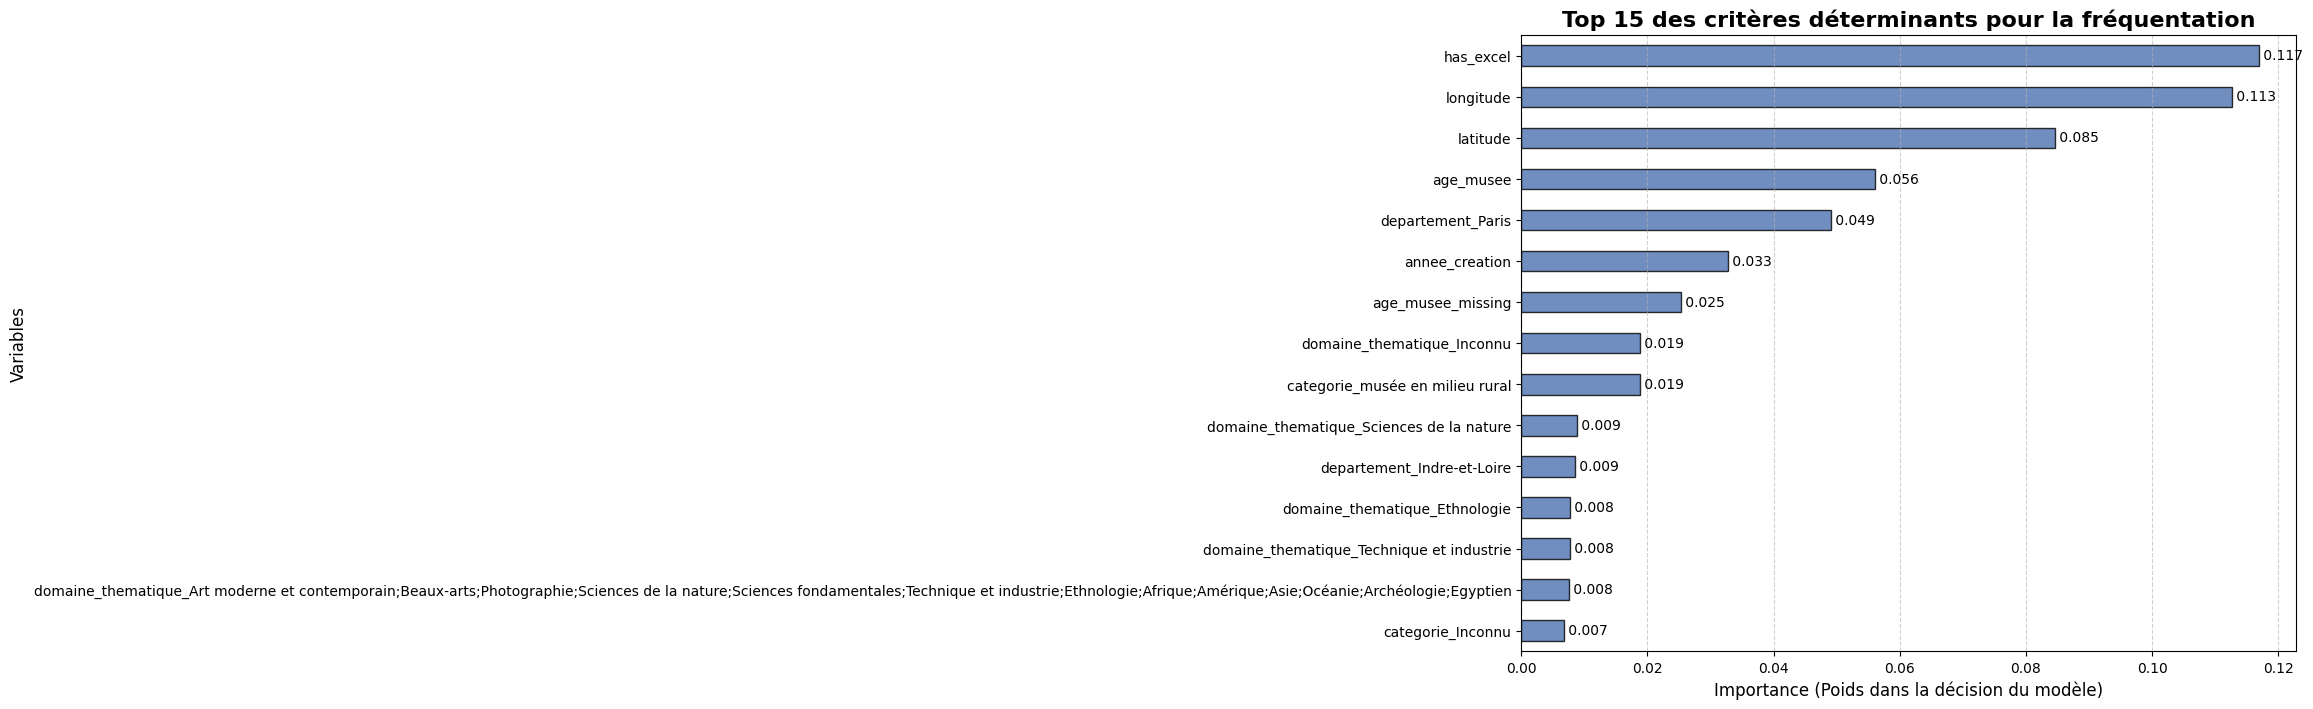

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# ==============================================================================
# VISUALISATION DES FEATURE IMPORTANCES
# ==============================================================================

# 1. Récupération des importances brutes calculées par le modèle
importances = model.feature_importances_
feature_names = X_train.columns

# 2. On met ça dans un tableau propre pour trier
forest_importances = pd.Series(importances, index=feature_names)

# 3. On garde les 15 variables les plus influentes (Top 15)
# On trie par ordre croissant pour l'affichage (la plus importante en haut)
top_features = forest_importances.nlargest(15).sort_values()

# 4. Création du graphique
plt.figure(figsize=(10, 8))
top_features.plot(kind='barh', color='#4c72b0', edgecolor='black', alpha=0.8)

plt.title("Top 15 des critères déterminants pour la fréquentation", fontsize=16, fontweight='bold')
plt.xlabel("Importance (Poids dans la décision du modèle)", fontsize=12)
plt.ylabel("Variables", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# On affiche les valeurs au bout des barres pour plus de lisibilité
for index, value in enumerate(top_features):
    plt.text(value, index, f' {value:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [19]:
print(df.columns.tolist())

['id_patrimostat', 'id_museofile', 'dateappellation', 'ferme', 'anneefermeture', 'ville', 'codeInseeCommune', 'annee', 'payant', 'gratuit', 'total', 'individuel', 'scolaires', 'groupes_hors_scolaires', 'moins_18_ans_hors_scolaires', '_18_25_ans', 'part_gratuit', 'part_scolaires', 'part_individuels', 'nom_officiel', 'region', 'departement', 'categorie', 'domaine_thematique', 'annee_creation', 'latitude', 'longitude', 'total_frequentation', 'age_musee', 'age_musee_missing', 'total_t_1', 'croissance_total', 'has_excel', 'est_idf']
